**Dataset :** https://gitlab.com/our-sci/real-food-campaign/rfc-docs/-/blob/master/2020/dataset/cleaned3.csv (4518, 4053)

## A bit of context

We want to predict the amount of polyphenols, antioxidants and brix in vegetables based on scans on the vegetables realised with a spectrometer. The scans give us an absorbance value for a wavelength. For instance, if we send a blue light (that correspond to a certain wavelength) on a carrot, the carrot will absorbe some part of the light and reject another part (our data). The idea here is to predict the nutritional quality (with our 3 targets) of a vegetable based on the scans results. To do this, we create a sub-dataset with 4 types of columns :
<ul><li>The targets : (polyphenols, antioxidants and brix).</li><li>The surface scan columns : We send to the vegetables 10 different wavelengths (on per color) and observe the results.</li><li>The juice scan columns : We transform our vegetables in juices by crushing them and we do the same process as the surface scan columns.</li><li>The sample type : What kind of vegetable we have.</li></ul>

This is an illustration of the visible light spectrum with the differents wavelength per colors :

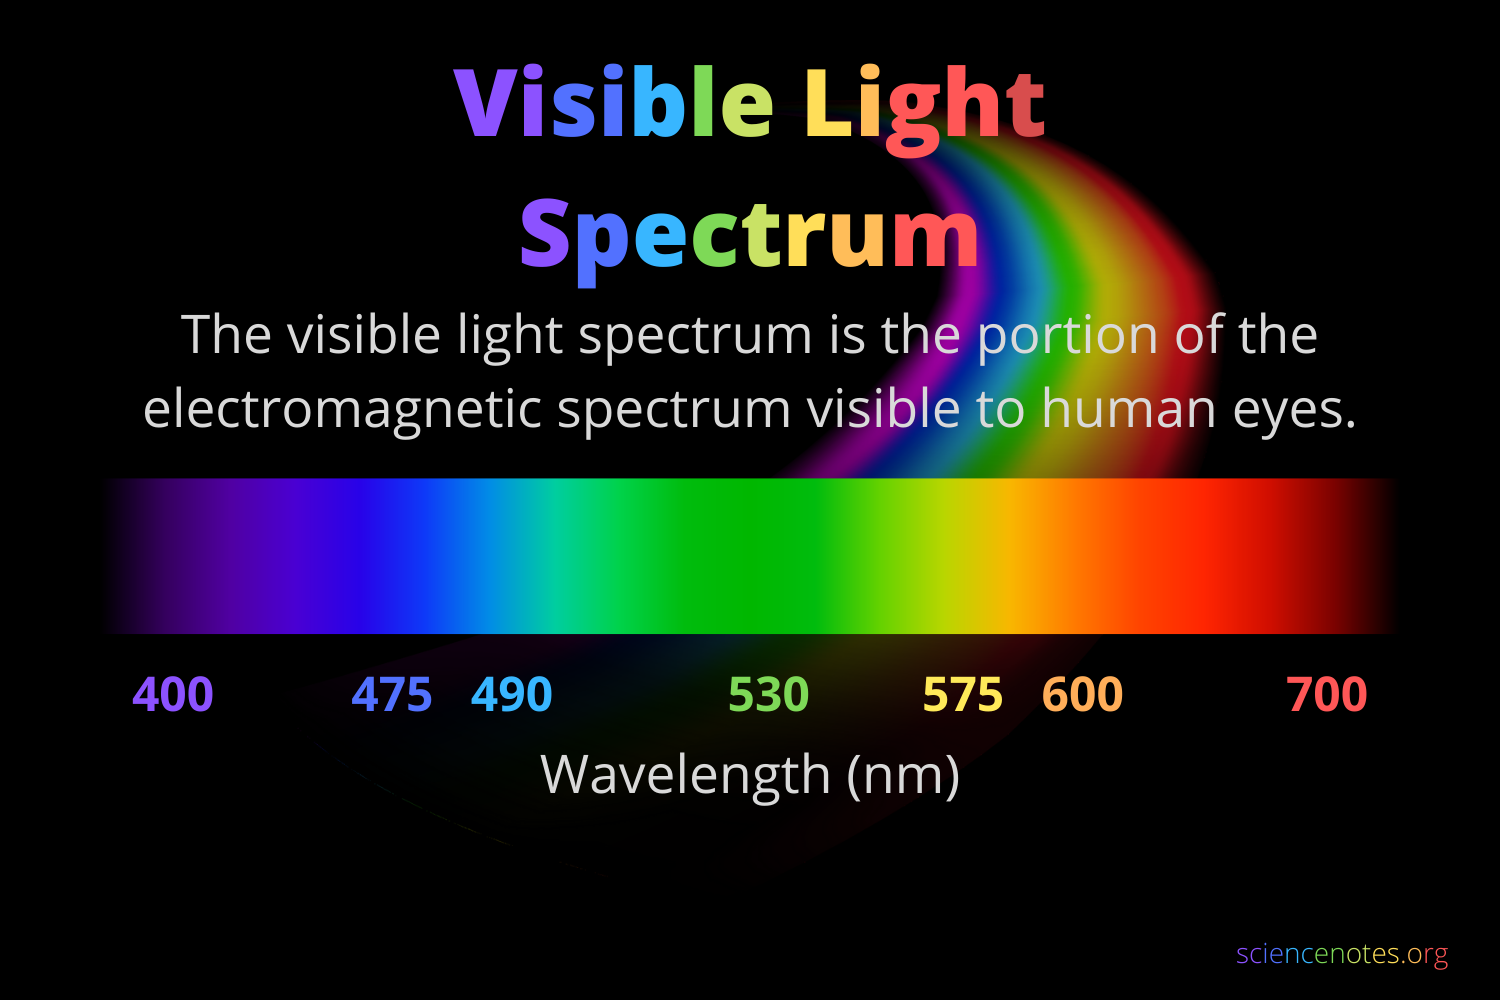

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename = "img/Visible-Light-Spectrum.png", width = 700, height = 700)

## Librairies import and sub-dataset creation

In [2]:
%load_ext autoreload
%autoreload 2

import nbimporter

import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import missingno as msno
sns.set_theme(style = 'darkgrid')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.multioutput import MultiOutputRegressor

# Modeling
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Outliers detection
from scipy.stats import ks_2samp

from methods import compare_variation, correlation_matrix, outliers_column, normalized_mean_std, \
kde_plot, violin_plot, qualitative_outliers_plot, fit_preprocessor, learning_curves, \
transform_preprocessor, get_performances, all_process, preprocess_fit, evaluate_models, \
plot_prediction_results, plot_perf_sampling, plot_forest_importances, compute_forest_importance, \
preprocess_and_evaluate, compute_perf_sampling, plot_perf_sampling, plot_most_importants_errors

In [3]:
data = pd.read_csv('Data2020/cleaned3.csv', low_memory=False)

In [4]:
targets = ['polyphenols_final', 'antioxidants_final', 'brix']
surface_cols = [X for X in data.columns if 'surface.scan' in X]
juice_cols = [X for X in data.columns if 'juice.scan' in X]

cols = surface_cols + juice_cols + targets + ['sample_type']
df = data[cols]

In [5]:
df = df.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Replace infinite values by NaN

# Replace sample type name
def replace_bok(x):
    if x == 'bok_choy_bok_choi_pak_choy':
        return 'bok_choy'
    else:
        return x
df['sample_type'] = df['sample_type'].apply(replace_bok)

## Missing values and overview of the dataset

Shape : (4518, 24)


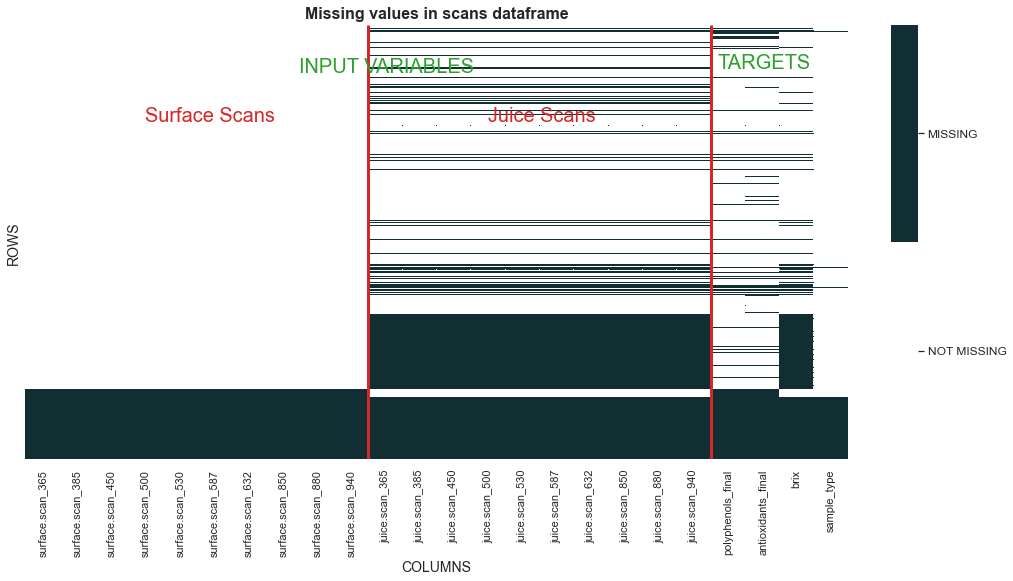

In [6]:
sns.set(font_scale=1)
cmap = sns.cubehelix_palette(start=2.5, rot=0, light=1, n_colors=2)
grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.1}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(16,8))

print('Shape :',df.shape)

sns.heatmap(df.isna(), ax=ax, yticklabels=False, cbar_ax=cbar_ax, cmap=ListedColormap(cmap), 
            cbar_kws={'orientation': 'vertical'})

cbar_ax.set_yticklabels(['NOT MISSING', 'MISSING'], fontsize=12)
cbar_ax.yaxis.set_ticks([ 0.25, 0.75])

# set title, x and y labels
ax.set_title('Missing values in scans dataframe', fontsize=16, fontweight="bold")
ax.set_ylabel('ROWS', fontsize=14)
ax.set_xlabel('COLUMNS', fontsize=14)

# line to separate the two columns
ax.vlines(len(surface_cols), *ax.get_ylim(), color="tab:red", lw = 3)
ax.vlines(len(surface_cols)+len(juice_cols), *ax.get_ylim(), color="tab:red", lw = 3)
# categoy of the two columns
ax.text(3.5,1000, 'Surface Scans', fontsize=20, color='tab:red')
ax.text(13.5,1000, 'Juice Scans', fontsize=20, color='tab:red')
ax.text(8,500, 'INPUT VARIABLES', fontsize=20, color='tab:green')
ax.text(20.2,450, 'TARGETS', fontsize=20, color='tab:green')
_ = plt.show()

## Targets distributions

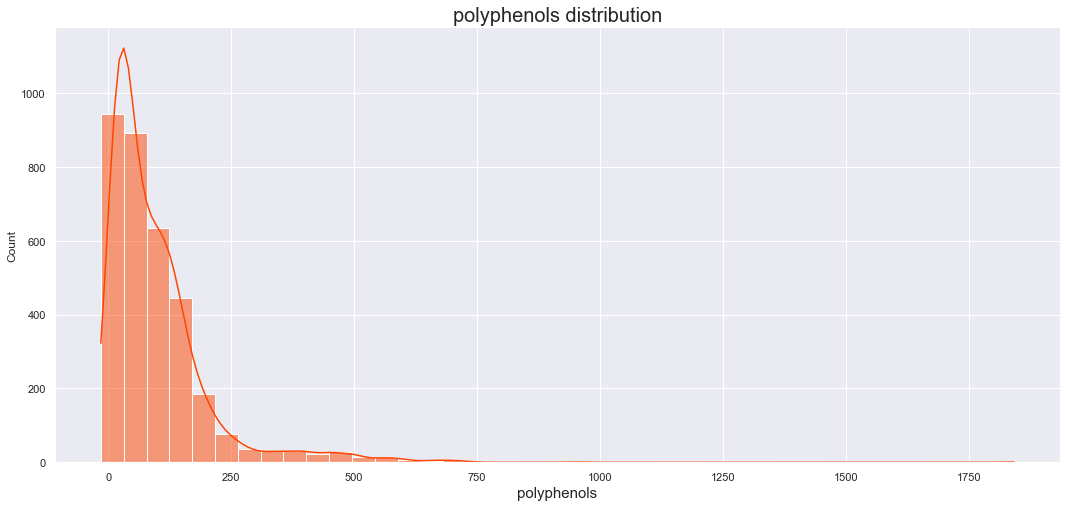

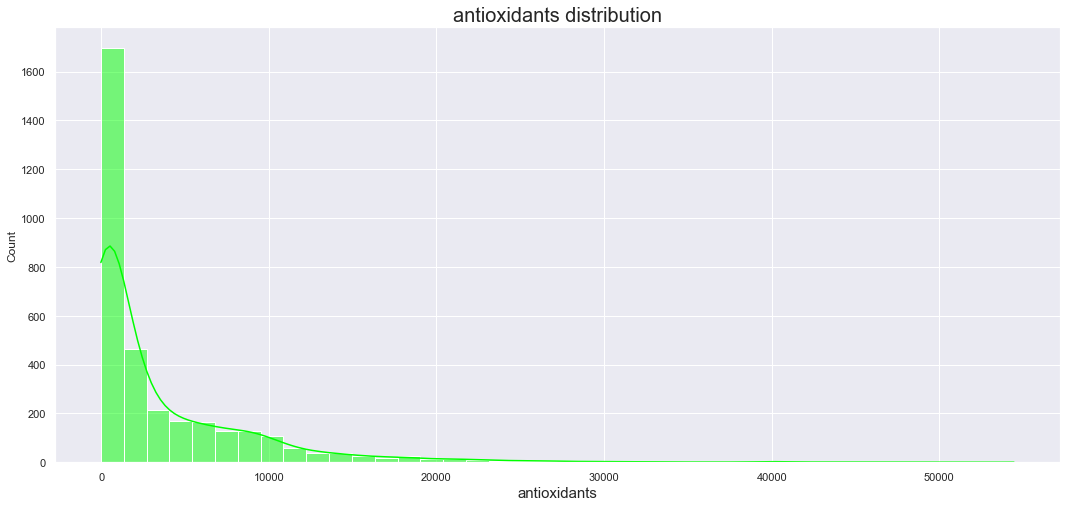

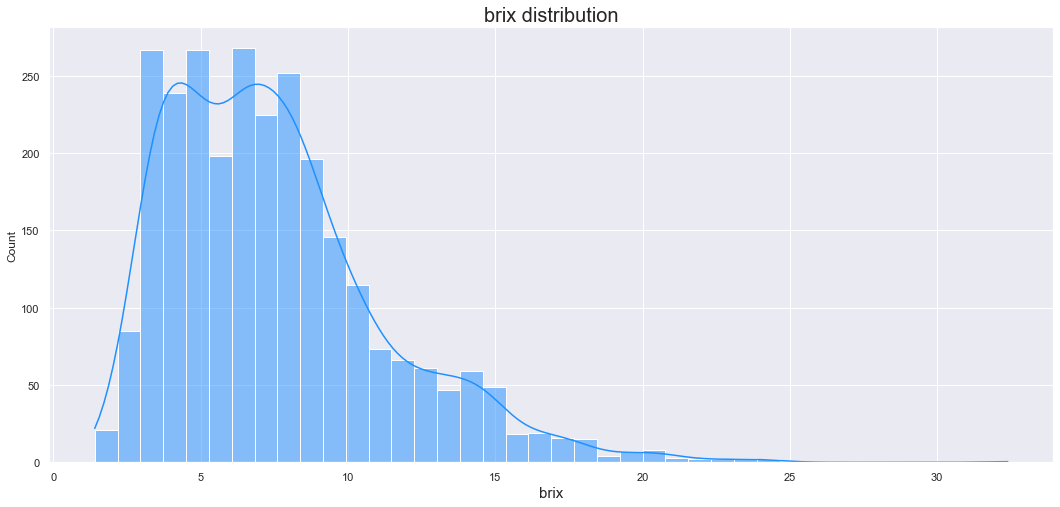

In [7]:
colors = ['orangered', 'lime', 'dodgerblue']
for target in targets:
    plt.figure(figsize = (18, 8))
    plt.title(target.replace('_final','')+' distribution', fontsize = 20)
    sns.histplot(data=df, x=target, bins = 40, color = colors[targets.index(target)], kde = True)
    plt.xlabel(target.replace('_final',''), fontsize = 15)
    plt.show()

The graphs don't show it really well, but there are some outliers on our targets. An outlier is a value that differs significantly from other observations. For instance, if most of our data is included in the interval $[0,10]$ (the case for the brix), an outlier would be a value upper than 20 or lesser than -10. This can be problematic for our model because those values are hard to predict if you do not now in which case they occurs.

## Sample Type repartition

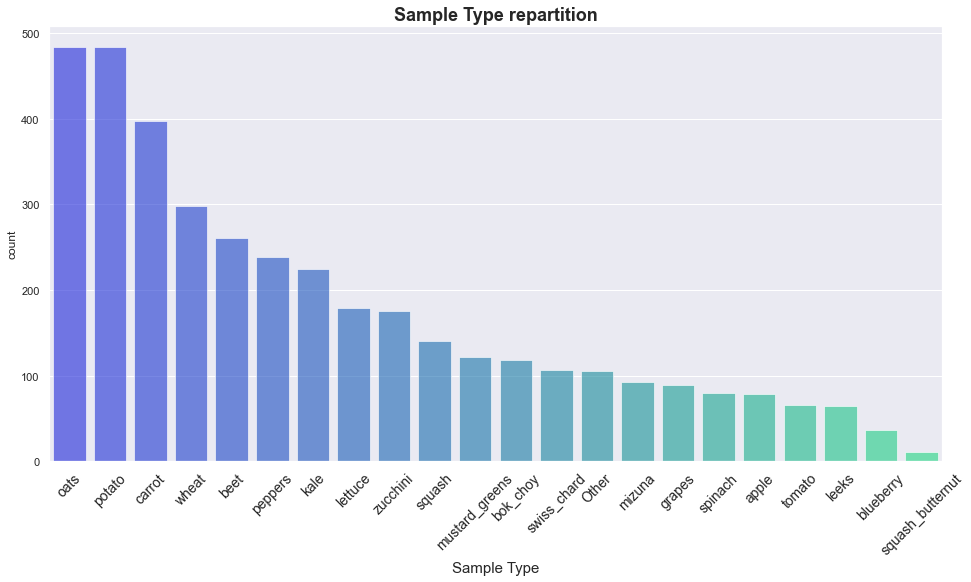

In [8]:
plt.figure(figsize = (16, 8))
sns.countplot(x="sample_type", data=df, order=df['sample_type'].value_counts().index, palette = 'winter', \
              alpha = .6)
plt.xticks(rotation=45)
plt.title('Sample Type repartition', fontsize = 18, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.xlabel('Sample Type', fontsize = 15)
plt.show()

## Scans distributions

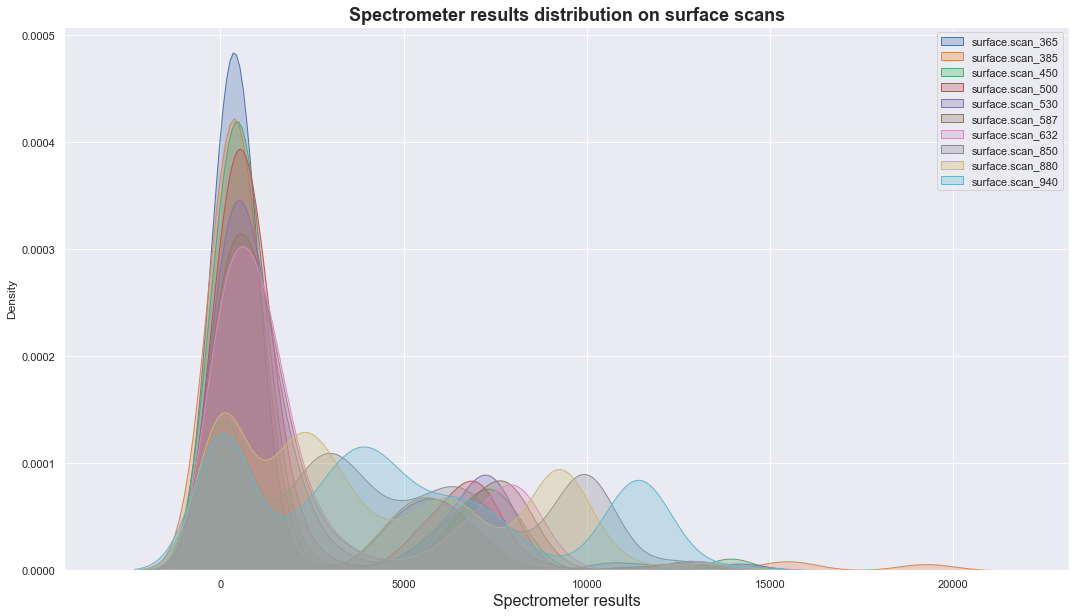

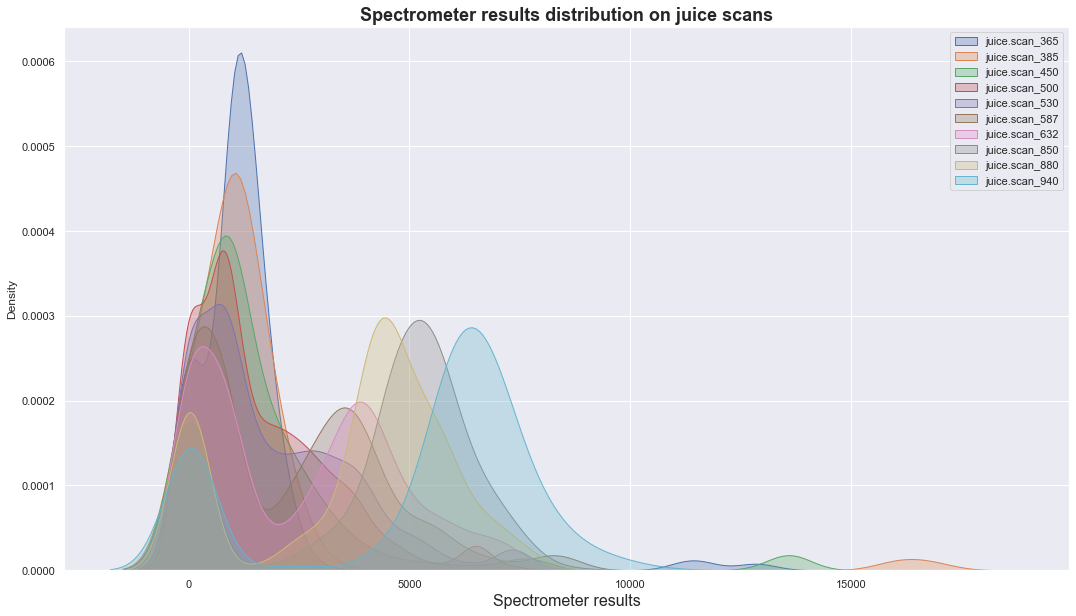

In [9]:
kde_plot(df, surface_cols, 
           title = 'Spectrometer results distribution on surface scans', 
           xlabel = 'Spectrometer results', 
           alpha = .3,
           fill = True)

kde_plot(df, juice_cols, 
           title = 'Spectrometer results distribution on juice scans', 
           xlabel = 'Spectrometer results', 
           alpha = .3,
           fill = True)

We can see that surface scans results range is larger than the juice scans results. It means that juice scan values are more aggregated between 0 and 10 000 than surface scan values where the range lies between 0 and 15 000. Mathematically speaking, it seems that juice scans results have a lower variance and a lower mean than surface scan results.

## Central tendency and dispersion anlaysis on scan features

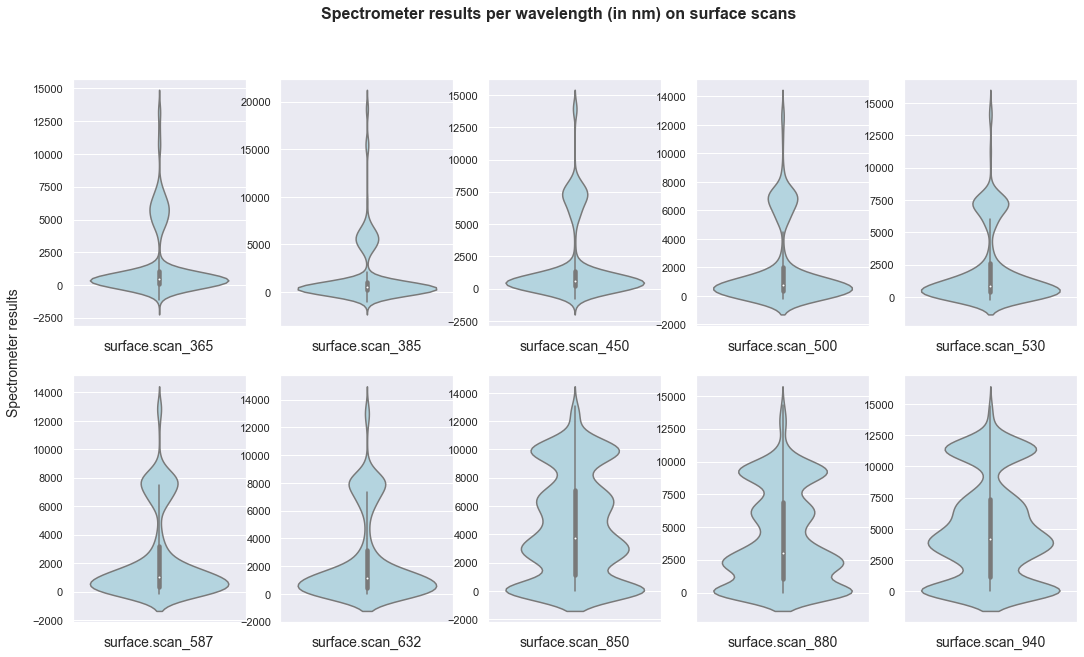

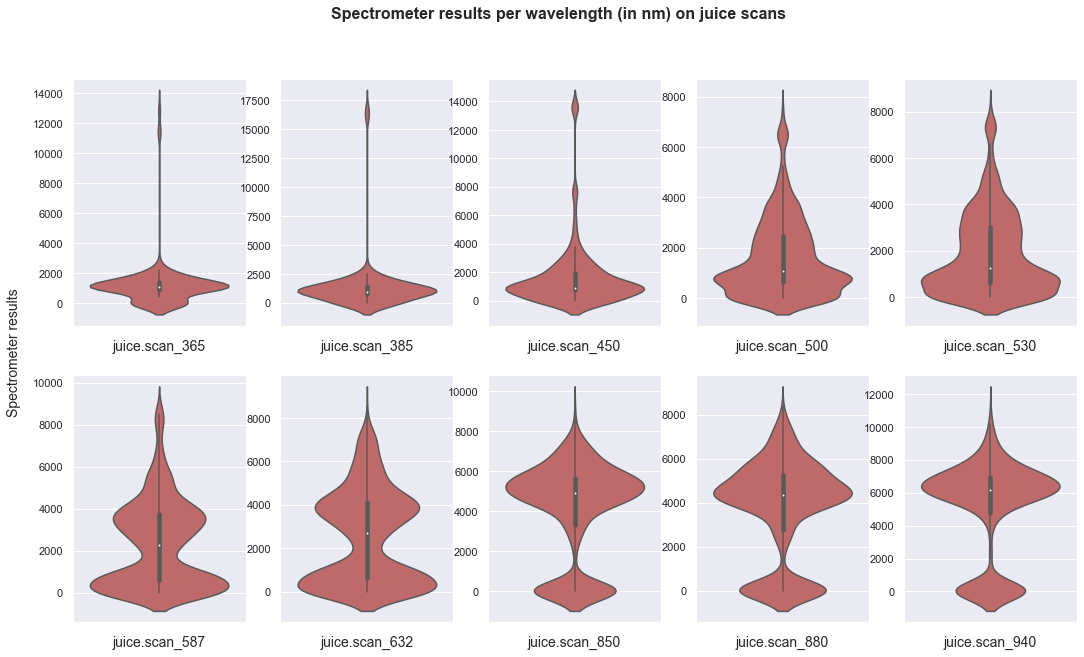

In [10]:
violin_plot(df, 
            surface_cols, 
            title = 'Spectrometer results per wavelength (in nm) on surface scans', 
            ylabel = 'Spectrometer results', 
            color = 'lightblue', 
            figsize=(18, 10))

violin_plot(df, 
            juice_cols, 
            title = 'Spectrometer results per wavelength (in nm) on juice scans', 
            ylabel = 'Spectrometer results', 
            color = 'indianred', 
            figsize=(18, 10))

Thoses graphs give us interesting insights on our scans data repartition. First, for the surface scans, we can see that the data from 365 nm to 632 nm have a pretty similar repartiton and same for the data between 850 and 940. We can then identify 2 main groups. <br>
On juice scans, we can see that the 3 first wavelengths are similarly distributed and same thing for the 3 last. We then have 2 groups. However, data between 500 nm and 632 nm seems to constitute a 3rd group with a distribution between the 2 groups we first identified.

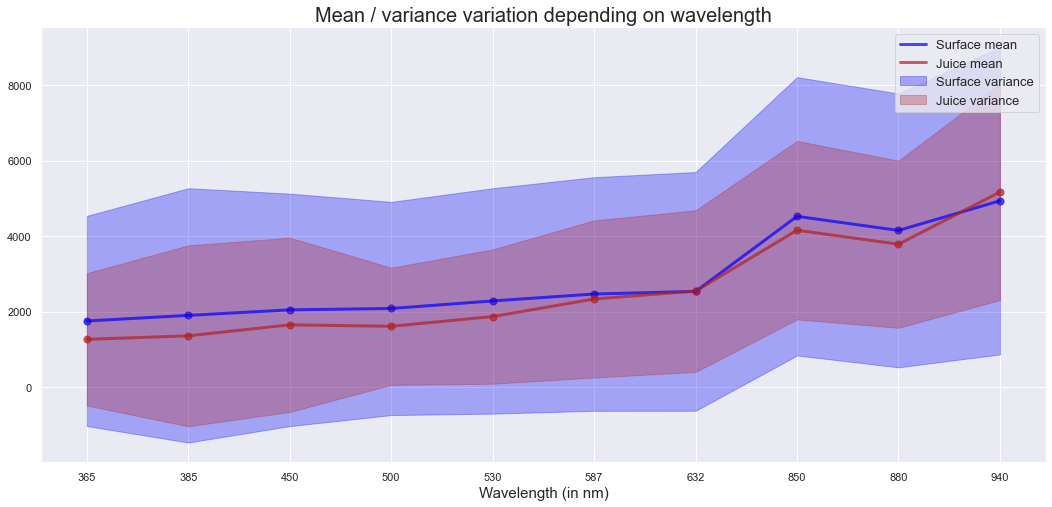

In [11]:
labels = [X.replace('surface.scan_','') for X in surface_cols]
compare_variation(df = df, l1 = surface_cols, l2 = juice_cols, labels = labels,
                  l1_name = 'Surface', l2_name = 'Juice', xlabel = 'Wavelength (in nm)',
                  title = 'Mean / variance variation depending on wavelength',
                  c1 = 'blue', c2 = 'firebrick', scale=False)

We can see that as we supposed before, surface data has an higher average and variance than juice data (except for the 940 nm data). We can also find the results of the violin plots, we can see a clear difference between the interval before 632 nm (included) and after 632 nm. It might be related to the fact that after 632 nm, we exit the visible light spectrum range and enter the infrared. This could explain the different results there.

## Correlations in the data

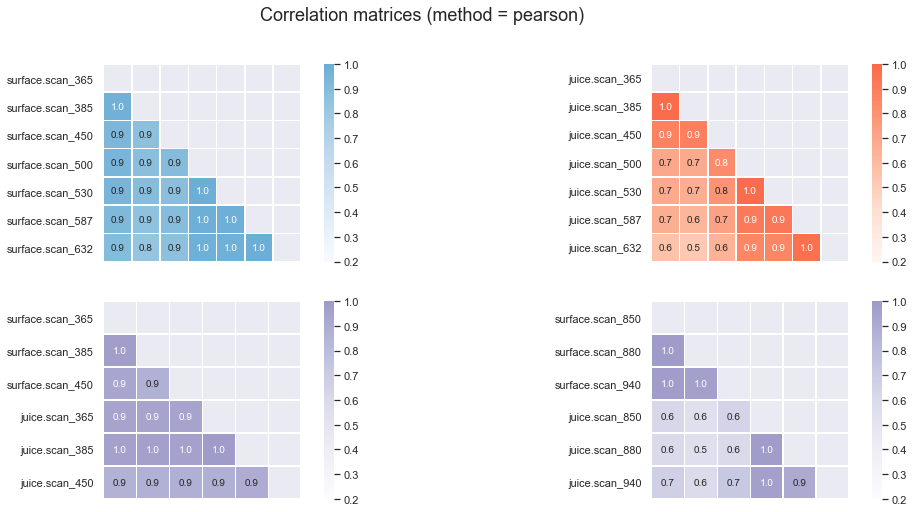

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))

correlation_matrix(df[surface_cols[:7]], cmap = 'Blues', fmt = ".1f", ax = ax[0, 0])
correlation_matrix(df[juice_cols[:7]], cmap = 'Reds', fmt = ".1f", ax = ax[0, 1])

correlation_matrix(df[surface_cols[:3] + juice_cols[:3]], cmap = 'Purples', fmt = ".1f", ax = ax[1, 0])
correlation_matrix(df[surface_cols[-3:] + juice_cols[-3:]], cmap = 'Purples', fmt = ".1f", ax = ax[1, 1])
plt.suptitle('Correlation matrices (method = pearson)', fontsize = 18)
plt.show()

Those matrix show us correlations between the groups that we identified earlier. But it also shows us for instance that the first group of the surface scan is highly correlated with the first group of the juice scan, but it is not the case for the last groups.

## Modelisation

We enter there in the modelisation phase. We didn't preprocessed a lot our data. We tried several things, such as Fourier transform or Savitzky-Golay algorithm but it didn't increased our models' performances. So we almost did nothing except for a KNNImputer to replace NaN values on our numerical data and a OneHotEncoder for the sample type column.

In [22]:
models = {'Linear Regression':LinearRegression(),
          'Ridge Regression':Ridge(alpha=1, solver="auto"),
          'Random Forest':RandomForestRegressor(n_estimators=1000, random_state = 0)}

In [14]:
_, _, _, _, _, _ = all_process(df.dropna(axis = 0, subset = targets),
                                         targets, models, 
                                         num_features = surface_cols + juice_cols,
                                         cat_features = ['sample_type'],
                                         method_result = 'uniform_average')

============================================ Train set =============================================
      Linear Regression  Ridge Regression  Random Forest
MAE              684.76            684.01         196.86
RMSE            2195.19           2196.53         792.20
R²                 0.64              0.64           0.95
============================================= Test set =============================================
      Linear Regression  Ridge Regression  Random Forest
MAE              729.37            726.58         522.74
RMSE            2379.72           2374.11        2114.96
R²                 0.60              0.60           0.67


We can see that Random Forest has the best performances on the test set. We averaged our result to print 1 result per metric, but R² set apart, our metrics don't really make sense because our targets does not have the same range.

A small reminder on the error metrics used here :
<ul><li>Mean Absolute Error (MAE) : We mesure the error (the difference between our prediction and the truth) for each observation in absolute value and we sum it. We then divide by the number of observation to get a mean error. We compute it the following way : 
    $MAE = \frac{1}{n}.\sum_{i=1}^n | y_{true}-y_{predicted} |$</li>
    <li>Root Mean Squared Error (RMSE) : The idea is the same as MAE, but this time, instead of using the absolute value we square each difference, sum it and calculate the mean. It gives use the Mean Squared Error (MSE) and if we want to go back to our original unit, we put a square root on the result, this is the RMSE. This measure penalizes a lot the high differences between observation and prediction. When MSE and MAE are close, only small mistakes have been comitted by the model. But when the difference is big, it means that for some value, our model predict far away from the observed value. We compute it the following way : 
        $RMSE =  \sqrt{\frac{1}{n}.\sum_{i=1}^n (y_{true}-y_{predicted})^2}$</li>
    <li>Coefficient of determination (R²) : The R² is the mean squared error (MSE) normalized by the squared deviation of the observation to the mean. For each error, we scale it by the distance between the observed data and the mean of the observed data. Thus, the result does not depend on the scale of the data. It is a coefficient between $-\inf$ (for the worst model) and $1$ (for a perfect model). We compute it the following way : 
        $\LARGE R^2 = 1 - \frac{\sum_{i=1}^n (y_{true}-y_{predicted})^2}{\sum_{i=1}^n (y_{true}-\bar{y}_{true})^2}$
    </li>
</ul>

In [15]:
df[targets].describe()

,polyphenols_final,antioxidants_final,brix
count,3374.000000,3357.000000,2734.000000
mean,97.132644,3650.685496,7.524872
std,107.761476,5592.394681,3.711911
min,-14.740000,-19.050000,1.400000
25%,28.867500,148.080000,4.700000
50%,67.615000,1310.260000,6.900000
75%,129.367500,5198.950000,9.300000
max,1840.900000,54452.550000,32.400000


In [16]:
X_train, y_train, X_test, y_test, models_final, preprocessor = all_process(df.dropna(axis = 0, subset = targets), 
                                                                           targets, models,
                                                                           num_features = surface_cols + juice_cols,
                                                                           cat_features = ['sample_type'],
                                                                           normalized_results = False)

============================================ Train set =============================================
           Linear Regression        Ridge Regression          Random Forest
MAE   [39.47, 2013.54, 1.26]  [39.52, 2011.26, 1.26]  [12.95, 577.22, 0.42]
RMSE  [72.67, 3801.48, 1.78]   [72.69, 3803.8, 1.78]  [26.0, 1371.89, 0.61]
R²        [0.57, 0.61, 0.74]      [0.57, 0.61, 0.74]     [0.95, 0.95, 0.97]
============================================= Test set =============================================
          Linear Regression        Ridge Regression           Random Forest
MAE   [40.82, 2145.9, 1.39]  [40.75, 2137.61, 1.39]  [35.44, 1531.58, 1.19]
RMSE  [68.24, 4121.23, 1.9]   [68.08, 4111.51, 1.9]  [64.88, 3662.64, 1.64]
R²       [0.53, 0.52, 0.74]      [0.54, 0.52, 0.74]       [0.58, 0.62, 0.8]


<p>The result for each metric is a vector of 3 elements (one per targets). The order is the following : <br>
    <b>[Value for the Polyphenols, value for the Antioxidants, Value for the Brix]</b> <br>
    For instance, the MAE for the polyphenol on the training set for the Linear Regression is 39.47. We can see that our models have a great efficiency to predict Brix, but they struggle to predict Polyphenols and Antioxidants. The main cause is the presence of outliers. Indeed there is far more (around 2.5) outliers on those two targets than Brix. Our models fail to predict the presence of outliers. Let's visualize our predictions for the Random Forest Regressor.
</p>

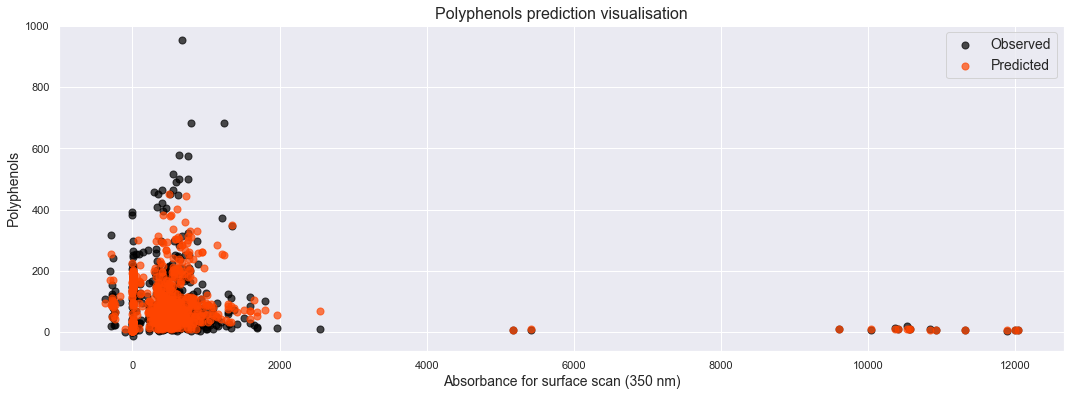

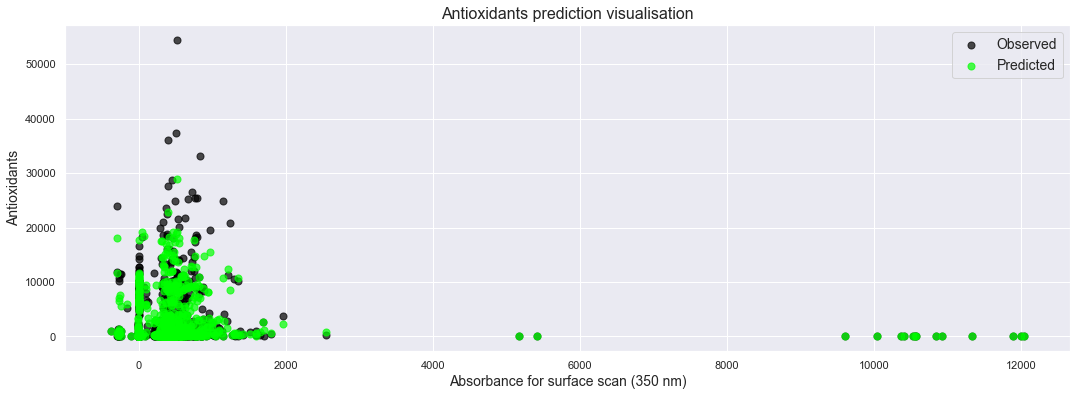

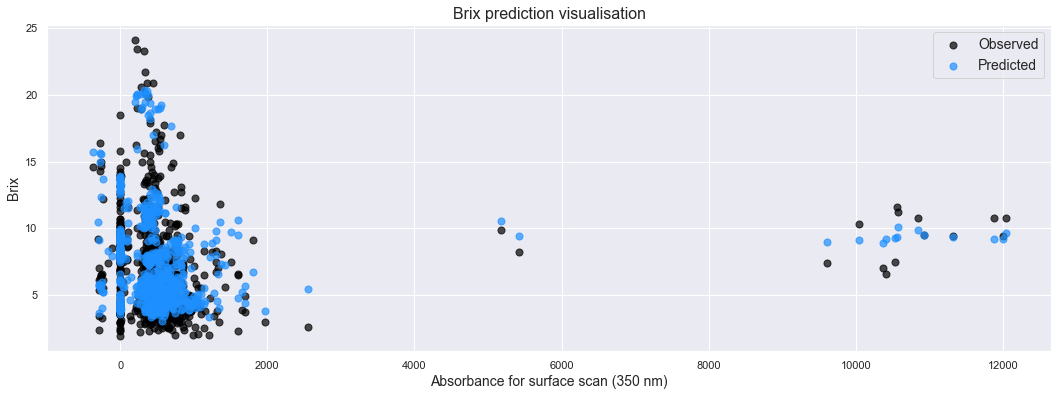

In [17]:
y_hat = models['Random Forest'].predict(X_test)
names = ['Polyphenols', 'Antioxidants', 'Brix']
plot_prediction_results(X_test[:, 0], y_test, y_hat, targets, names, colors,
                       xlabel = 'Absorbance for surface scan (350 nm)')

Note : The absciss variable has been choosen arbitrarily but allows a pretty good visualisation of our model perfomance.

We can plot the the values where the Mean Squared Error is the most important to see in which case our model fail to predict the targets correctly

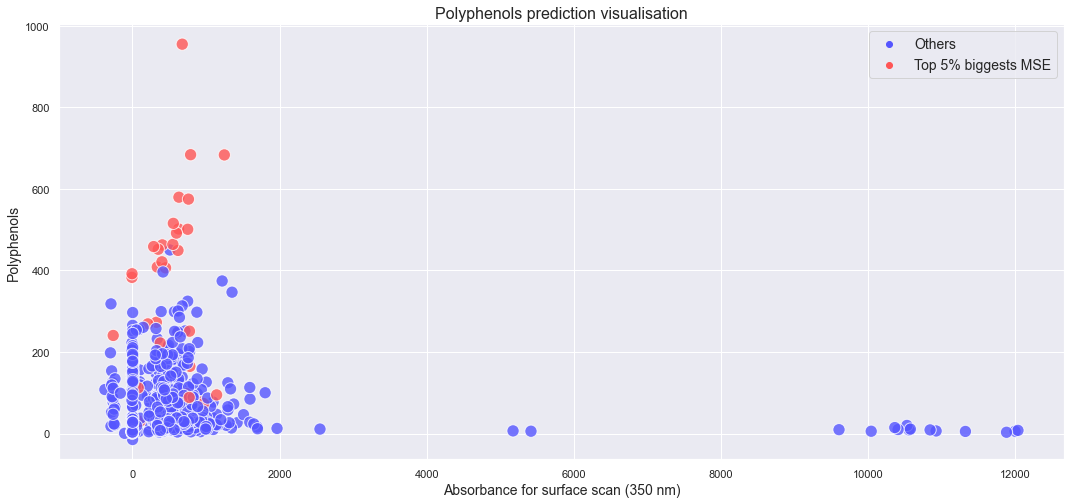

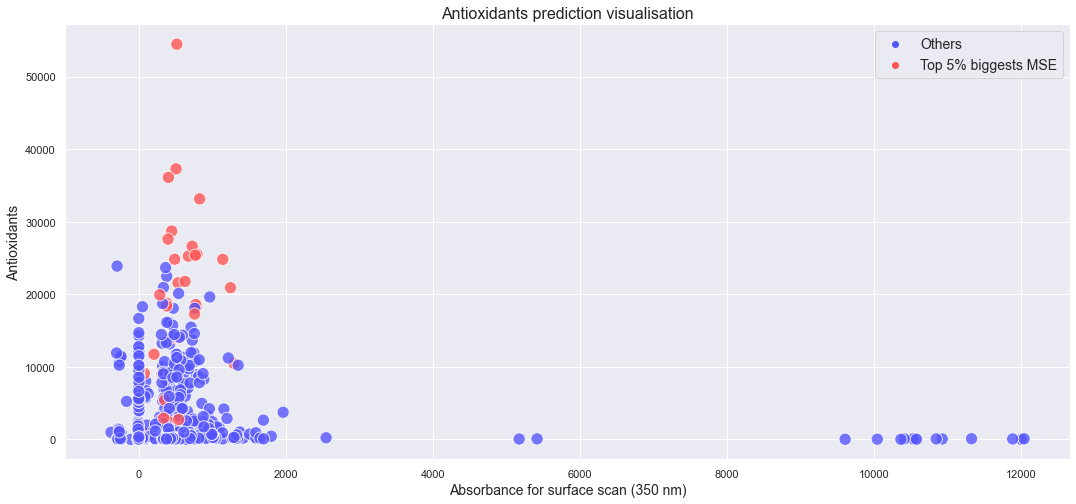

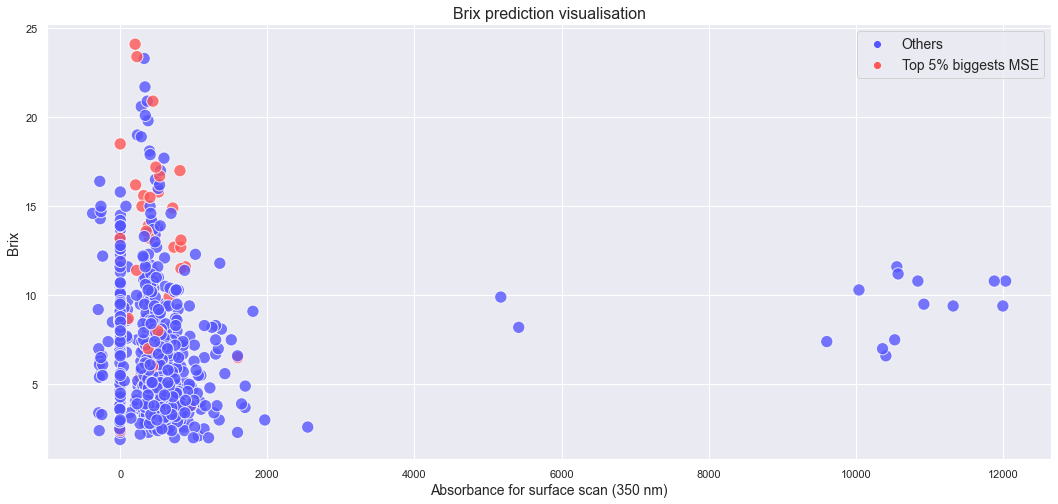

In [18]:
plot_most_importants_errors(X_test[:, 0], y_test, y_hat, targets,
                            names, xlabel = 'Absorbance for surface scan (350 nm)')

We can see that the most important errors occur (on antioxidants and polyphenols) when the model tries to predict outliers. It confirms the hypothesis we did before with the relationship between the outliers and the bad performances. To increase the performance of the model, it seems really important to understand where the outliers comes from and if there is a way to predict them.

## Sampling evolution

As you saw before, for each scan (juice and surface) we did measures for 10 differents wavelength. In this part we tried to see if adding more scan features will generate an increase in our models' performances. So for each type of scan, we tried to add features one by one and see how it impact the results of our models.

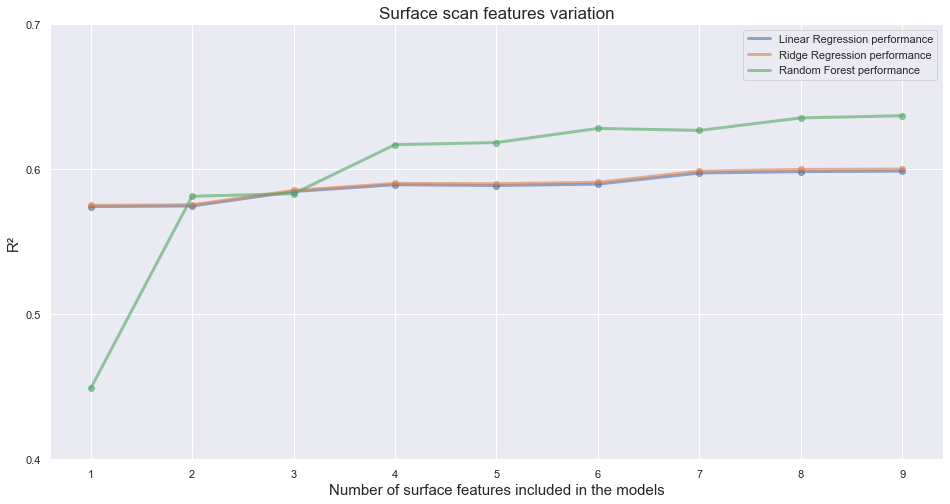

In [19]:
md, performance, number_i = compute_perf_sampling(models,
                                                  surface_cols,
                                                  juice_cols,
                                                  pd.DataFrame(np.fliplr(X_train), columns = list(df.dropna(axis=0, subset = targets)['sample_type'].unique()) + surface_cols + juice_cols), 
                                                  y_train,
                                                  pd.DataFrame(np.fliplr(X_test), columns = list(df.dropna(axis=0, subset = targets)['sample_type'].unique()) + surface_cols + juice_cols), 
                                                  y_test)

plot_perf_sampling(md, 
                   performance, 
                   number_i, 
                   'Surface scan features variation',
                   xlabel = 'Number of surface features included in the models')

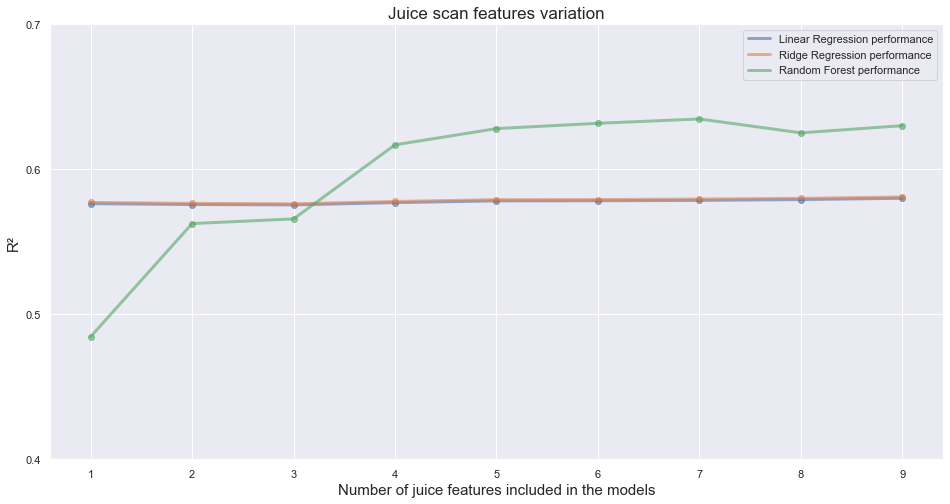

In [20]:
md2, performance2, number_i2 = compute_perf_sampling(models,
                                                     juice_cols,
                                                     surface_cols,
                                                     pd.DataFrame(np.fliplr(X_train), columns = list(df.dropna(axis=0, subset = targets)['sample_type'].unique()) + surface_cols + juice_cols),
                                                     y_train,
                                                     pd.DataFrame(np.fliplr(X_test), columns = list(df.dropna(axis=0, subset = targets)['sample_type'].unique()) + surface_cols + juice_cols), 
                                                     y_test)

plot_perf_sampling(md2, 
                   performance2, 
                   number_i2, 
                   title = 'Juice scan features variation', 
                   xlabel = 'Number of juice features included in the models')

Note : The sample type is included in those models

## Learning curves

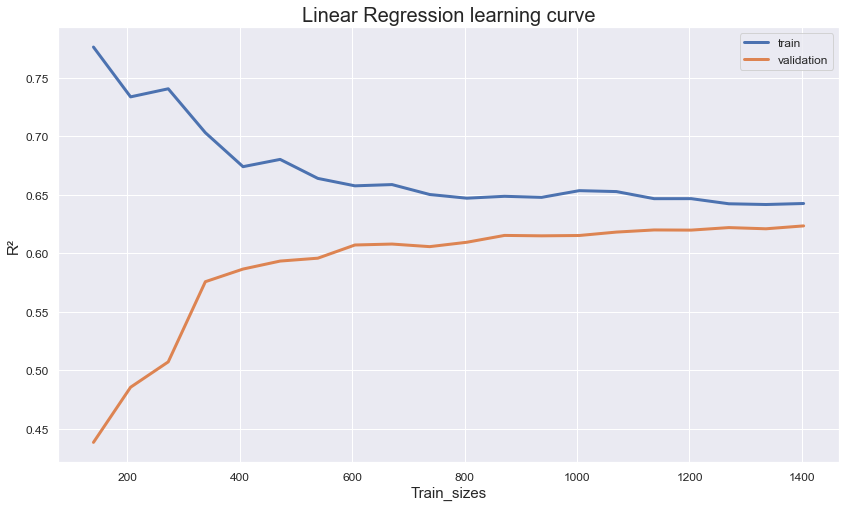

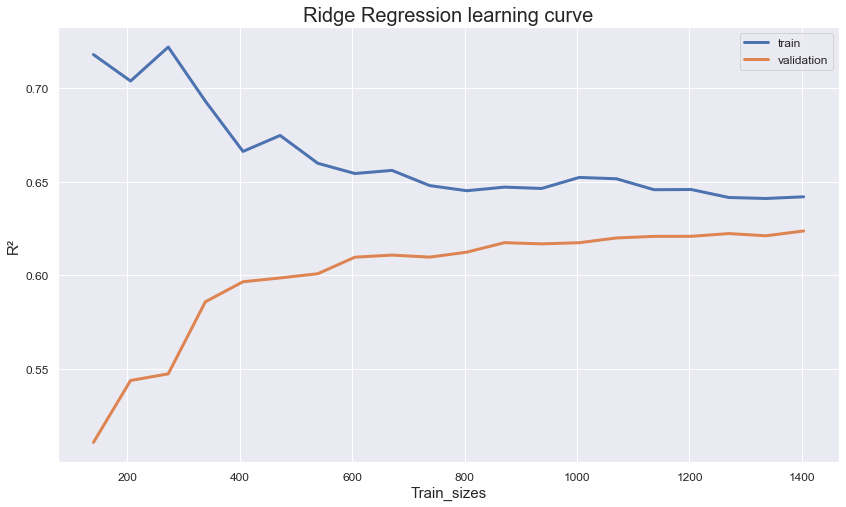

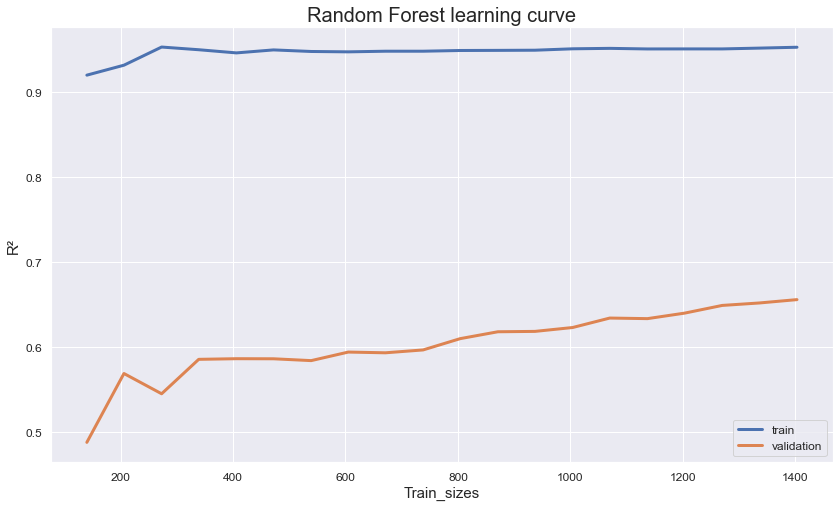

In [21]:
for k, v in models.items():
    learning_curves(v, k, X_train, y_train)